In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [189]:
def parse_data(s):
    s = s.split(" ")[0]
    mese = s.split("-")[1]
    giorno = s.split("-")[2]
    
    return giorno + "/" + str(int(mese))

def min_max_normalization( arr):
    minv= min(arr)
    maxv= max(arr)
    arr = [(x-minv)/(maxv-minv) for x in arr]
    return arr

dati = pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')
giorni = list(map(parse_data, dati["data"].values))
percentages = [ str(x) + '%' for x in np.array([0.0, 25.0, 50.0, 75.0, 100.0])]

# nuovi tamponi giornalieri
numero_tamponi = dati["tamponi"].values
delta_tamponi = [numero_tamponi[0]]
for g in range(len(numero_tamponi) - 1):
    delta_tamponi += [numero_tamponi[g+1] - numero_tamponi[g]]
    
# percentuale nuovi_positivi/nuovi_tamponi
div = lambda x: x[0]/x[1] if 0<(x[0]/x[1])<1 else None
ratio_nuovi_pos_nuovi_tamp = list(map(div, list(zip(dati["nuovi_attualmente_positivi"], delta_tamponi))))

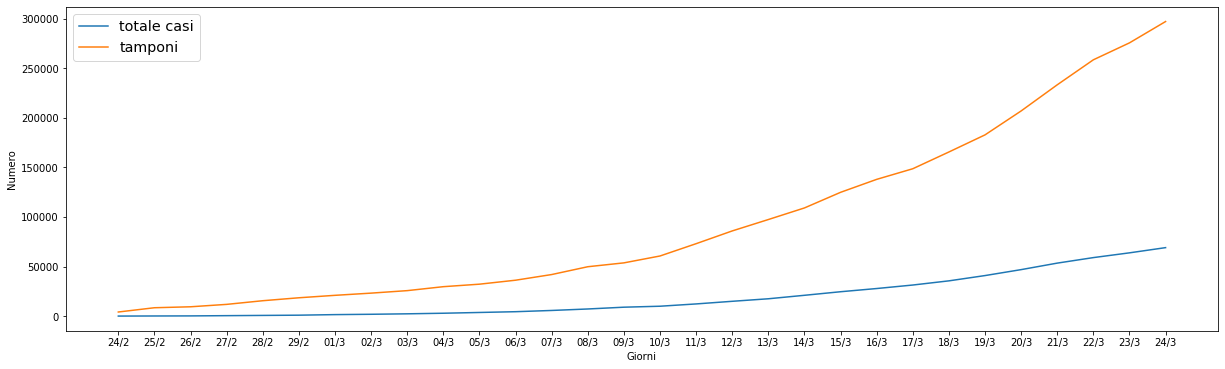

In [190]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')
ax.plot(giorni, dati['totale_casi'], label='totale casi')
ax.plot(giorni, dati['tamponi'], label='tamponi')
ax.legend(fontsize='x-large')

fig.set_size_inches(20, 5)
plt.show()

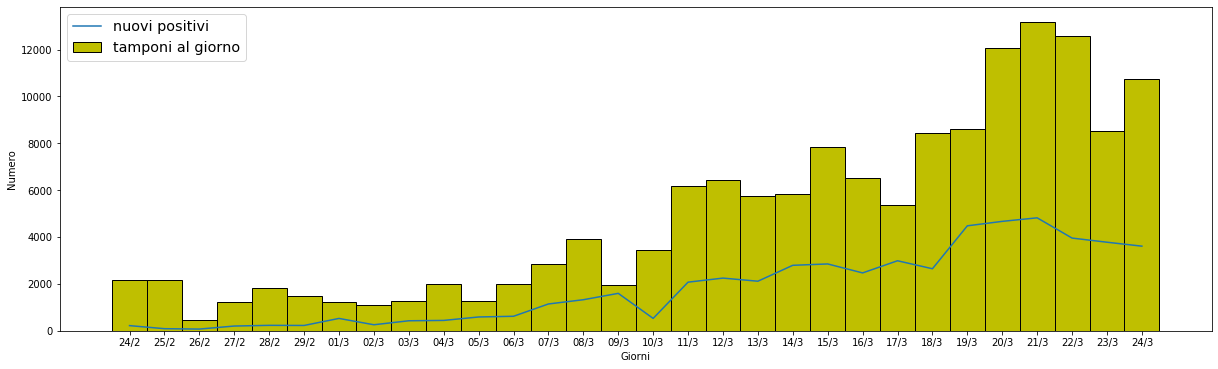

In [191]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')
line_positivi = ax.plot(giorni, dati['nuovi_attualmente_positivi'], label="nuovi positivi")
bar_tamp = ax.bar(giorni, list(map(lambda x: x*0.5, delta_tamponi)), color="y", width=1, edgecolor="k", label="tamponi al giorno")
ax.legend(fontsize='x-large')

fig.set_size_inches(20, 5)
plt.show()

In [192]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')
line_positivi = ax.plot(giorni, ratio_nuovi_pos_nuovi_tamp, label="nuovi positivi")
bar_tamp = ax.bar(giorni, min_max

SyntaxError: unexpected EOF while parsing (<ipython-input-192-5d44c9139c88>, line 7)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.8, 0.9])

ax.set_xlabel('Giorni')
ax.set_ylabel('Percentuale')
line_positivi = ax.plot(giorni, ratio_nuovi_pos_nuovi_tamp, label="copertura tamponi")
bar_tamp = ax.bar(giorni, min_max_normalization(delta_tamponi), color="y", width=1, edgecolor="k", label="tamponi al giorno")
ax.set_yticks(np.arange(0, 1.25, step=0.25))
ax.set_yticklabels(percentages)
ax.legend(fontsize='x-large')

fig.set_size_inches(20, 5)
plt.show()